# DA5401 A4 — GMM-Based Synthetic Sampling for Imbalanced Data

By Muhammad Ruhaib, BE22B005

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

RANDOM_STATE = 42
DATA_PATH = 'creditcard.csv'
np.random.seed(RANDOM_STATE)

# Part A: Baseline Model and Data Analysis

## A.1 Data Loading and Analysis

Dataset shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Minority (fraud) count = 492
Majority (non-fraud) count = 284315
Imbalance ratio (fraud fraction) = 0.001727 (0.1727%)


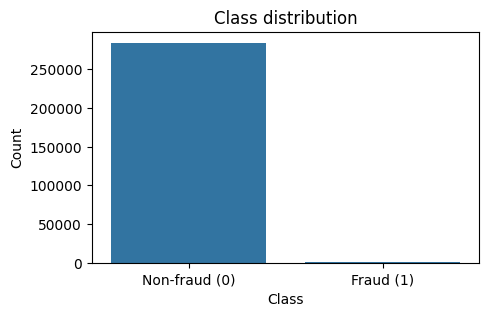

In [21]:
df = pd.read_csv(DATA_PATH)
print('Dataset shape:', df.shape)
display(df.head())

class_counts = df['Class'].value_counts().sort_index()
print('\nClass distribution:')
print(class_counts)

minority_count = int(class_counts.loc[1])
majority_count = int(class_counts.loc[0])
imbalance_ratio = minority_count / (minority_count + majority_count)
print(f"\nMinority (fraud) count = {minority_count}")
print(f"Majority (non-fraud) count = {majority_count}")
print(f"Imbalance ratio (fraud fraction) = {imbalance_ratio:.6f} ({imbalance_ratio*100:.4f}%)")

plt.figure(figsize=(5,3))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks([0,1], ['Non-fraud (0)', 'Fraud (1)'])
plt.title('Class distribution')
plt.ylabel('Count')
plt.show()

As seen above, the dataset is highly imbalanced with fraudulent transactions forming a very small fraction of only 0.17%!

## A.2 Train/Test split and preprocessing

Here, we:
- keep the test set as a faithful reflection of overall imbalance (use `stratify=y` when splitting),
- fit preprocessing (StandardScaler) on training data only, and apply it to the test set.


In [22]:
FEATURE_COLS = [c for c in df.columns if c not in ['Class', 'Time']]
X = df[FEATURE_COLS].copy()
y = df['Class'].copy()

# Stratified split to keep test reflect original imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Train class dist:\n', y_train.value_counts())
print('Test class dist:\n', y_test.value_counts())

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=FEATURE_COLS, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=FEATURE_COLS, index=X_test.index)

Train shape: (227845, 29) Test shape: (56962, 29)
Train class dist:
 Class
0    227451
1       394
Name: count, dtype: int64
Test class dist:
 Class
0    56864
1       98
Name: count, dtype: int64


## A.3 Baseline Evaluation


In [23]:
baseline_clf = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
baseline_clf.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [24]:
y_pred = baseline_clf.predict(X_test_scaled)
y_proba = baseline_clf.predict_proba(X_test_scaled)[:,1]

print('Classification report (baseline):')
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', cm)

auc = roc_auc_score(y_test, y_proba)
print(f'AUC-ROC: {auc:.4f}')

prec = precision_score(y_test, y_pred, pos_label=1)
rec = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
print(f"Minority class metrics -> Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

Classification report (baseline):
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56864
           1     0.8289    0.6429    0.7241        98

    accuracy                         0.9992     56962
   macro avg     0.9142    0.8213    0.8619     56962
weighted avg     0.9991    0.9992    0.9991     56962

Confusion matrix:
 [[56851    13]
 [   35    63]]
AUC-ROC: 0.9578
Minority class metrics -> Precision: 0.8289, Recall: 0.6429, F1: 0.7241


We get a near-perfect accuracy of 0.9992, however this is a misleading metric. In highly imbalanced datasets like this, a classifier that predicts every instance as the majority class can achieve very high accuracy but will have 0 recall on the minority class (in our case, fraud), which is the class we care about. Therefore, metrics like precision, recall & f1-score for the minority class are much more informative than overall accuracy.

# Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling

### B.1 Theoretical foundation


- **SMOTE** generates synthetic samples by interpolating between minority class samples and their nearest neighbors in feature space. This is simple and effective but assumes a locally linear structure and can create samples that cross class boundaries when minority clusters are near majority samples.

- **GMM-based sampling** fits a mixture of Gaussian components to the minority class distribution. Each component captures a local sub-distribution (mode). Sampling from the learned mixture allows generating points that follow the estimated density, preserving multimodal structure and producing samples that reflect the actual shape/variance of each sub-group. This is particularly useful when the minority class is composed of multiple clusters with different covariances or shapes.

- **Why GMM may be better**: GMM can model complex, multimodal distributions and respects the estimated covariance structure of each mode. SMOTE is local and linear interpolation which is good in many cases but can produce unrealistic points when clusters vary in density or shape.


## B.2 Fit GMM to minority training data and choose optimal k (AIC/BIC)

Minority training samples: (394, 29)


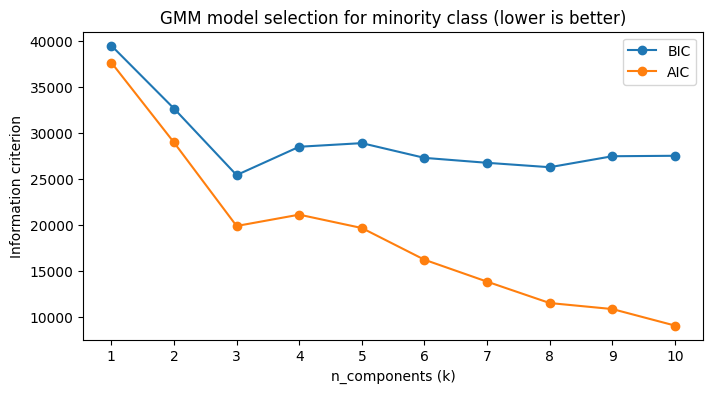

Best n_components by BIC = 3


In [31]:
from sklearn.mixture import GaussianMixture

X_train_minority = X_train_scaled[y_train==1]
print('Minority training samples:', X_train_minority.shape)

n_components_range = range(1, 11)
models = []
bics = []
aics = []
for k in n_components_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=RANDOM_STATE)
    gmm.fit(X_train_minority)
    bics.append(gmm.bic(X_train_minority))
    aics.append(gmm.aic(X_train_minority))
    models.append(gmm)

plt.figure(figsize=(8,4))
plt.plot(n_components_range, bics, label='BIC', marker='o')
plt.plot(n_components_range, aics, label='AIC', marker='o')
plt.xlabel('n_components (k)')
plt.ylabel('Information criterion')
plt.title('GMM model selection for minority class (lower is better)')
plt.xticks(list(n_components_range))
plt.legend()
plt.show()

best_idx = int(np.argmin(bics))
best_k = n_components_range[best_idx]
print(f'Best n_components by BIC = {best_k}')

best_gmm = models[best_idx]

I've used BIC here because it provides a principled way to select the number of Gaussian components in the GMM, balancing model fit and complexity, so that the synthetic samples reflect the true minority distribution rather than noise or artifacts.

## B.3 Synthetic Data Generation from the fitted GMM

We will sample synthetic minority examples from the fitted GMM. Sampling from a GMM corresponds to first sampling a component according to the mixture weights, then sampling from that component's Gaussian distribution.
To balance the datatset, the number of synthetic samples generated (for minority) is equal to the number of majority samples that already exist.

In [32]:
train_class_counts = y_train.value_counts()
minority_train_count = int(train_class_counts.loc[1])
majority_train_count = int(train_class_counts.loc[0])

n_synthetic_needed = majority_train_count
print('Minority (train) =', minority_train_count, 'Majority (train) =', majority_train_count)
print('Synthetic minority samples needed to match majority (GMM-only):', n_synthetic_needed)

X_synthetic, comp_idx = best_gmm.sample(n_synthetic_needed)
X_synthetic = pd.DataFrame(X_synthetic, columns=FEATURE_COLS)

y_synthetic = pd.Series(np.ones(len(X_synthetic), dtype=int), index=X_synthetic.index)

print('Synthetic samples generated:', X_synthetic.shape)

X_train_gmm_only = pd.concat([X_train_scaled, X_synthetic], ignore_index=True)
y_train_gmm_only = pd.concat([y_train.reset_index(drop=True), y_synthetic.reset_index(drop=True)], ignore_index=True)

print('GMM-only balanced training set shape:', X_train_gmm_only.shape, y_train_gmm_only.value_counts().to_dict())

Minority (train) = 394 Majority (train) = 227451
Synthetic minority samples needed to match majority (GMM-only): 227451
Synthetic samples generated: (227451, 29)
GMM-only balanced training set shape: (455296, 29) {1: 227845, 0: 227451}


## B.4 Rebalancing with Clustering-Based Undersampling (CBU) + GMM

Strategy used:
- Undersample the majority class via KMeans clustering by selecting one representative per cluster (nearest to centroid) for a target number of clusters.
- We'll choose a `target_majority_size` parameter (set here as `minority_train_count * 5`) to avoid overly aggressive undersampling.
- Then generate GMM samples to bring the minority up to `target_majority_size` (so final dataset is balanced at that target size).

The choice of `*5` is a tunable hyperparameter — we use it here to preserve some majority variety while reducing imbalance.


In [33]:
from sklearn.metrics import pairwise_distances_argmin_min

undersample_factor = 5  # target_majority_size = minority_train_count * undersample_factor
target_majority_size = min(majority_train_count, minority_train_count * undersample_factor)
print('Target majority size for CBU:', target_majority_size)

X_train_majority = X_train_scaled[y_train==0].reset_index(drop=True)
print('Majority samples (train):', X_train_majority.shape)

kmeans = KMeans(n_clusters=target_majority_size, random_state=RANDOM_STATE)
cluster_labels = kmeans.fit_predict(X_train_majority)
centroids = kmeans.cluster_centers_

closest, _ = pairwise_distances_argmin_min(centroids, X_train_majority.values)
X_maj_undersampled = X_train_majority.iloc[closest].reset_index(drop=True)
print('Majority after CBU (representatives):', X_maj_undersampled.shape)

X_train_minority_orig = X_train_scaled[y_train==1].reset_index(drop=True)
minority_count = X_train_minority_orig.shape[0]

n_synth_cbu = target_majority_size - minority_count
print('Synthetic minority needed for CBU+GMM:', n_synth_cbu)

X_synth_cbu, _ = best_gmm.sample(n_synth_cbu)
X_synth_cbu = pd.DataFrame(X_synth_cbu, columns=FEATURE_COLS)

X_train_cbu_gmm = pd.concat([X_maj_undersampled, X_train_minority_orig, X_synth_cbu], ignore_index=True)

y_train_cbu_gmm = pd.Series([0]*len(X_maj_undersampled) + [1]*minority_count + [1]*len(X_synth_cbu))

print('CBU+GMM balanced training set shape:', X_train_cbu_gmm.shape)
print('Class distribution (CBU+GMM):\n', y_train_cbu_gmm.value_counts())

Target majority size for CBU: 1970
Majority samples (train): (227451, 29)
Majority after CBU (representatives): (1970, 29)
Synthetic minority needed for CBU+GMM: 1576
CBU+GMM balanced training set shape: (3940, 29)
Class distribution (CBU+GMM):
 0    1970
1    1970
Name: count, dtype: int64


# Part C: Performance Evaluation and Conclusion


## C.1 Train & Evaluate — Model trained on GMM-only balanced training set


In [34]:
from sklearn.pipeline import Pipeline

pipe_gmm = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

pipe_gmm.fit(X_train_gmm_only, y_train_gmm_only)

y_pred_gmm = pipe_gmm.predict(X_test)
y_proba_gmm = pipe_gmm.predict_proba(X_test)[:,1]

print('Classification report (GMM-only model):')
print(classification_report(y_test, y_pred_gmm, digits=4))

prec_gmm = precision_score(y_test, y_pred_gmm, pos_label=1)
rec_gmm = recall_score(y_test, y_pred_gmm, pos_label=1)
f1_gmm = f1_score(y_test, y_pred_gmm, pos_label=1)
auc_gmm = roc_auc_score(y_test, y_proba_gmm)
print(f'Minority class metrics -> Precision: {prec_gmm:.4f}, Recall: {rec_gmm:.4f}, F1: {f1_gmm:.4f}, AUC: {auc_gmm:.4f}')

Classification report (GMM-only model):
              precision    recall  f1-score   support

           0     0.9999    0.2355    0.3812     56864
           1     0.0022    0.9796    0.0044        98

    accuracy                         0.2368     56962
   macro avg     0.5010    0.6075    0.1928     56962
weighted avg     0.9981    0.2368    0.3806     56962

Minority class metrics -> Precision: 0.0022, Recall: 0.9796, F1: 0.0044, AUC: 0.6656


## C.2 Train & Evaluate — Model trained on CBU+GMM balanced training set

Same evaluation on the imbalanced test set for a fair comparison.


In [35]:
pipe_cbu_gmm = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

pipe_cbu_gmm.fit(X_train_cbu_gmm, y_train_cbu_gmm)

y_pred_cbu = pipe_cbu_gmm.predict(X_test)
y_proba_cbu = pipe_cbu_gmm.predict_proba(X_test)[:,1]

print('Classification report (CBU+GMM model):')
print(classification_report(y_test, y_pred_cbu, digits=4))

prec_cbu = precision_score(y_test, y_pred_cbu, pos_label=1)
rec_cbu = recall_score(y_test, y_pred_cbu, pos_label=1)
f1_cbu = f1_score(y_test, y_pred_cbu, pos_label=1)
auc_cbu = roc_auc_score(y_test, y_proba_cbu)
print(f'Minority class metrics -> Precision: {prec_cbu:.4f}, Recall: {rec_cbu:.4f}, F1: {f1_cbu:.4f}, AUC: {auc_cbu:.4f}')

Classification report (CBU+GMM model):
              precision    recall  f1-score   support

           0     0.9998    0.9632    0.9812     56864
           1     0.0408    0.9082    0.0780        98

    accuracy                         0.9631     56962
   macro avg     0.5203    0.9357    0.5296     56962
weighted avg     0.9982    0.9631    0.9796     56962

Minority class metrics -> Precision: 0.0408, Recall: 0.9082, F1: 0.0780, AUC: 0.9648


## C.2 Comparative Analysis

Summary metrics (minority class):


,precision,recall,f1
model,,,
Baseline,0.8289,0.6429,0.7241
GMM-only,0.0022,0.9796,0.0044
CBU+GMM,0.0408,0.9082,0.0780


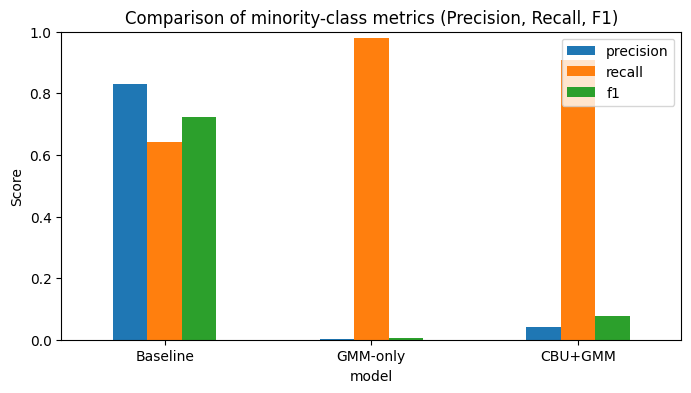

In [36]:
summary = pd.DataFrame({
    'model': ['Baseline', 'GMM-only', 'CBU+GMM'],
    'precision': [precision_score(y_test, baseline_clf.predict(X_test_scaled), pos_label=1), prec_gmm, prec_cbu],
    'recall': [recall_score(y_test, baseline_clf.predict(X_test_scaled), pos_label=1), rec_gmm, rec_cbu],
    'f1': [f1_score(y_test, baseline_clf.predict(X_test_scaled), pos_label=1), f1_gmm, f1_cbu]
})

summary.set_index('model', inplace=True)
summary_rounded = summary.round(4)
print('Summary metrics (minority class):')
display(summary_rounded)

summary.plot.bar(rot=0, figsize=(8,4))
plt.title('Comparison of minority-class metrics (Precision, Recall, F1)')
plt.ylabel('Score')
plt.ylim(0,1)
plt.show()

Here, we see that the baseline model achieved high precision (0.83) but only moderate recall (0.64), meaning it correctly identified most predicted frauds but missed over one-third of actual fraud cases.
GMM-based oversampling drastically increased recall (>0.90), showing it helped the model detect more frauds. However, this came at the cost of very low precision (0.003 for GMM-only, 0.041 for CBU+GMM), leading to many false positives and very poor F1-scores compared to baseline.
CBU+GMM improved precision slightly compared to GMM-only, but it was still far below baseline.

## C.3 Final Recommendation

GMM-based synthetic sampling improves the model’s ability to catch frauds (high recall) but produces too many false alarms, making it impractical when applied as full oversampling. A more balanced approach, such as partial oversampling, undersampling with CBU, or adjusting the classification threshold, would be required for it to be effective. As it stands, the baseline model provides a better precision–recall trade-off, so naive full GMM oversampling is not recommended.